Upon data preparation and the formulation of batch functions, we proceed to deploy Deep Learning for 3D segmentation through the adoption of a straightforward 3D U-net architecture. It is imperative to note that images are anticipated to manifest as 128x128x128x3 numpy arrays, where the '3' signifies the three channels attributed to test_image_flair, test_image_t1ce, and test_image_t2. Conversely, masks are envisaged as 128x128x128x3 numpy arrays, where '4' designates the four labels.

In [2]:
import os
import numpy as np
from Batch_functions import imageLoader
import tensorflow as tf
import keras
from matplotlib import pyplot as plt
import glob
import random
import segmentation_models_3D as sm
from Unet import simple_unet_model


#import segmentation_models as sm


Segmentation Models: using `tf.keras` framework.

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 128, 3)]   0         []                            
                                                                                                  
 conv3d (Conv3D)             (None, 128, 128, 128, 16)    1312      ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 128, 128, 128, 16)    0         ['conv3d[0][0]']              
                                                                                                  
 conv3d_1 (Conv3D)           (None, 128, 128, 128, 16)    6928      ['dropout[0][0]']             
                                           

Initially, we specify the directory containing the image and mask files. Subsequently, we visualize the data.

In [5]:
train_img_dir = 'd:/BraTS2020/train_dataset/train/images/'
train_mask_dir = 'd:/BraTS2020/train_dataset/train/masks/'

val_img_dir = 'd:/BraTS2020/train_dataset/val/images/'
val_mask_dir = 'd:/BraTS2020/train_dataset/val/masks/'

train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

val_img_list=os.listdir(val_img_dir)
val_mask_list = os.listdir(val_mask_dir)

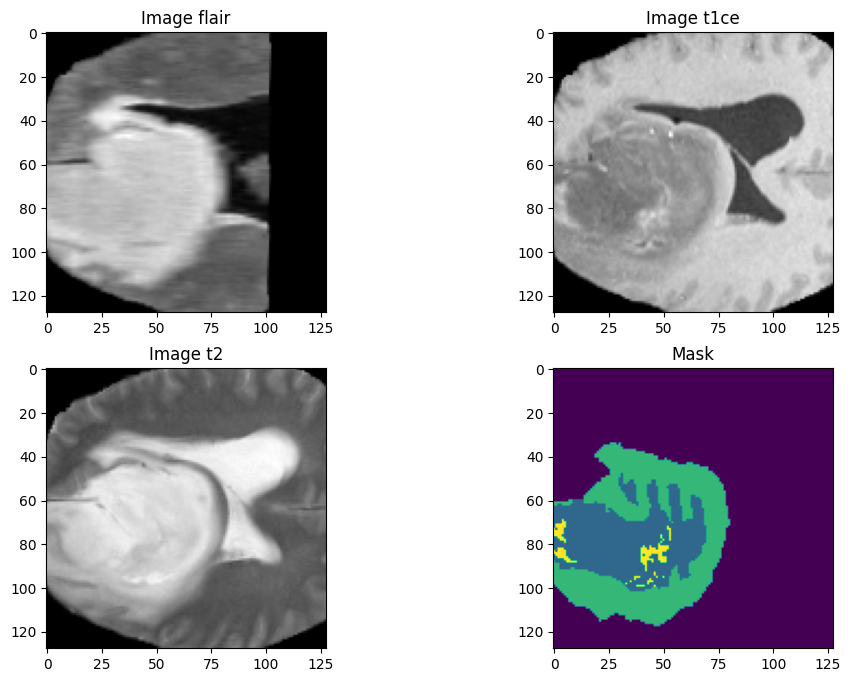

In [11]:
num_images = len(os.listdir(train_img_dir))

img_num = random.randint(0,num_images-1)
test_img = np.load(train_img_dir+train_img_list[img_num])
test_mask = np.load(train_mask_dir+train_mask_list[img_num])
test_mask = np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

Now that we check the correct visualization of the data, let's define train and validation. 

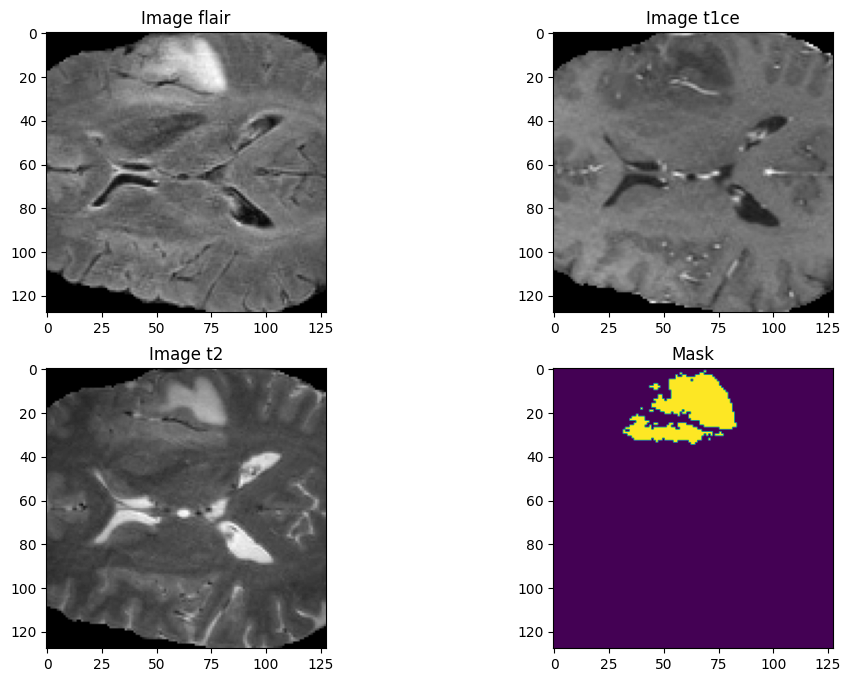

In [9]:
batch_size = 2 #if we had additional memory processing capacity, we could consider augmenting the batch size

train_img_datagen = imageLoader(train_img_dir, train_img_list, train_mask_dir, train_mask_list, batch_size)

val_img_datagen = imageLoader(val_img_dir, val_img_list, val_mask_dir, val_mask_list, batch_size)

#Verify generator.... In python 3 next() is renamed as __next__()
img, msk = train_img_datagen.__next__()

img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [10]:
#Define loss, metrics and optimizer to be used for training
wt0, wt1, wt2, wt3 = 0.25,0.25,0.25,0.25
dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2, wt3])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss) #we use total_loss because we obtained better results 

In [11]:
metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5)]

LR = 0.0001
optim = keras.optimizers.Adam(LR)

#let's fit the model

steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size

model = simple_unet_model(IMG_HEIGHT=128, 
                          IMG_WIDTH=128, 
                          IMG_DEPTH=128, 
                          IMG_CHANNELS=3, 
                          num_classes=4)

model.compile(optimizer = optim, loss=total_loss, metrics=metrics)
print(model.summary())

print(model.input_shape)
print(model.output_shape)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 128, 3)]   0         []                            
                                                                                                  
 conv3d_19 (Conv3D)          (None, 128, 128, 128, 16)    1312      ['input_2[0][0]']             
                                                                                                  
 dropout_9 (Dropout)         (None, 128, 128, 128, 16)    0         ['conv3d_19[0][0]']           
                                                                                                  
 conv3d_20 (Conv3D)          (None, 128, 128, 128, 16)    6928      ['dropout_9[0][0]']           
                                                                                            

In [15]:
import tensorflow as tf
from tensorflow import keras
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [19]:
history=model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=50,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )


Epoch 1/50


129/129 [==============================] - 3556s 27s/step - loss: 0.9554 - accuracy: 0.8656 - iou_score: 0.1953 - val_loss: 0.9438 - val_accuracy: 0.9503 - val_iou_score: 0.1985
Epoch 2/50
129/129 [==============================] - 3435s 27s/step - loss: 0.9382 - accuracy: 0.9520 - iou_score: 0.2227 - val_loss: 0.9366 - val_accuracy: 0.9501 - val_iou_score: 0.2229
Epoch 3/50
129/129 [==============================] - 3450s 27s/step - loss: 0.9275 - accuracy: 0.9468 - iou_score: 0.2409 - val_loss: 0.9214 - val_accuracy: 0.9321 - val_iou_score: 0.2837
Epoch 4/50
129/129 [==============================] - 3434s 27s/step - loss: 0.9172 - accuracy: 0.9414 - iou_score: 0.2941 - val_loss: 0.9147 - val_accuracy: 0.9308 - val_iou_score: 0.3248
Epoch 5/50
129/129 [==============================] - 3437s 27s/step - loss: 0.9076 - accuracy: 0.9472 - iou_score: 0.3340 - val_loss: 0.8968 - val_accuracy: 0.9554 - val_iou_score: 0.3770
Epoch 6/50
129/129 [==============================] -

In [20]:
model.save('Unet_3d_50.hdf5')

c:\Users\Windows\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


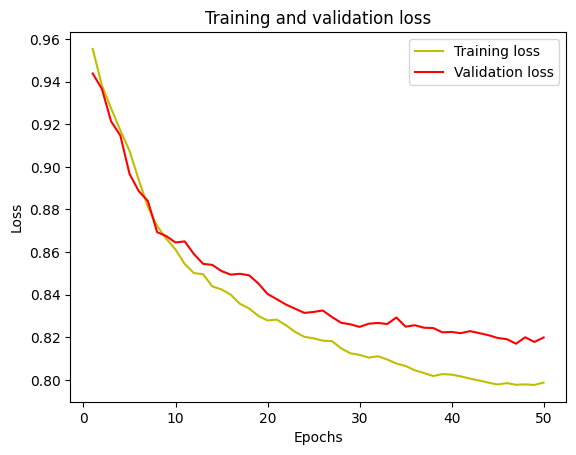

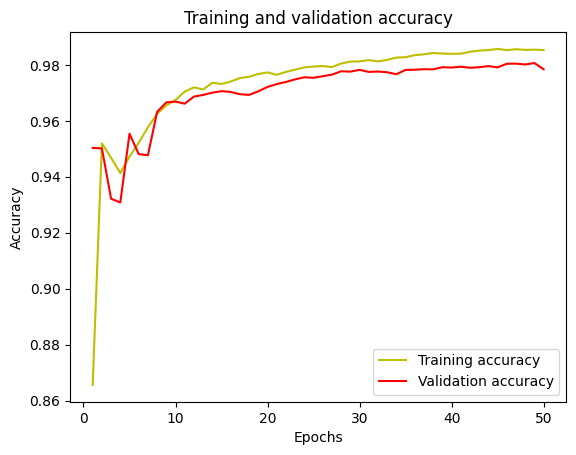

In [21]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [12]:
from keras.models import load_model
my_model = load_model('Unet_3d_50.hdf5', compile=False) #if i dont wan't to re train, just delete compile=False
#my_model = load_model('brats_3d.hdf5', custom_objects={'dice_loss_plus_1focal_loss': total_loss})

#Now, let us add the iou_score function we used during our initial training
my_model = load_model('Unet_3d_50.hdf5', custom_objects={'dice_loss_plus_1focal_loss': total_loss,'iou_score':sm.metrics.IOUScore(threshold=0.5)})

In [24]:
from keras.metrics import MeanIoU

batch_size=8 #Check IoU for a batch of images
test_img_datagen = imageLoader(val_img_dir, val_img_list, 
                                val_mask_dir, val_mask_list, batch_size)

#Verify generator.... In python 3 next() is renamed as __next__()
test_image_batch, test_mask_batch = test_img_datagen.__next__()

test_mask_batch_argmax = np.argmax(test_mask_batch, axis=4)
test_pred_batch = my_model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=4)

n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())


In [13]:
#Predict on a few test images, one at a time
#Try images: 
img_num = 82

test_img = np.load('d:/BraTS2020/train_dataset/val/images/image_'+str(img_num)+'.npy')

test_mask = np.load('d:/BraTS2020/train_dataset/val/masks/mask_'+str(img_num)+'.npy')
test_mask_argmax=np.argmax(test_mask, axis=3)

test_img_input = np.expand_dims(test_img, axis=0)
test_prediction = my_model.predict(test_img_input)
test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]

1/1 [==============================] - 3s 3s/step


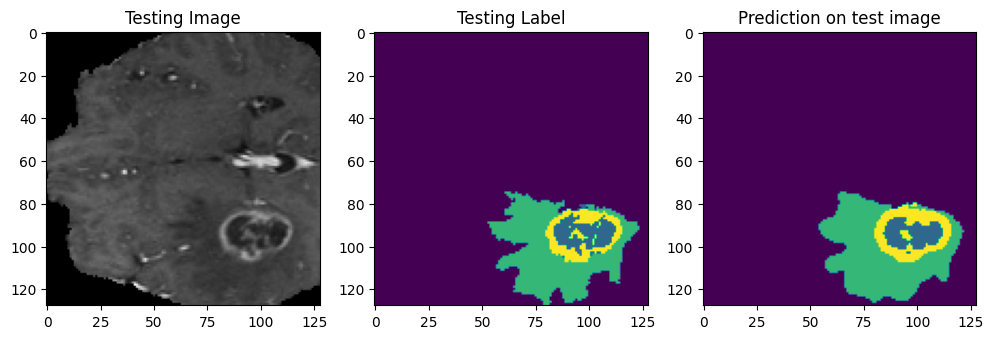

In [14]:
n_slice = 50
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,n_slice,1], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_argmax[:,:,n_slice])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction_argmax[:,:, n_slice])
plt.show()


In [73]:
#Predict on a few test images, one at a time
#Try images: 
img_num = 33
#45 va bien
test_img = np.load('d:/BraTS2020/validation_data_3channels/images/image_'+str(img_num)+'.npy')

#test_mask = np.load('d:/BraTS2020/train_dataset/val/masks/mask_'+str(img_num)+'.npy')
#test_mask_argmax=np.argmax(test_mask, axis=3)

test_img_input = np.expand_dims(test_img, axis=0)
test_prediction = my_model.predict(test_img_input)
test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]

1/1 [==============================] - 2s 2s/step


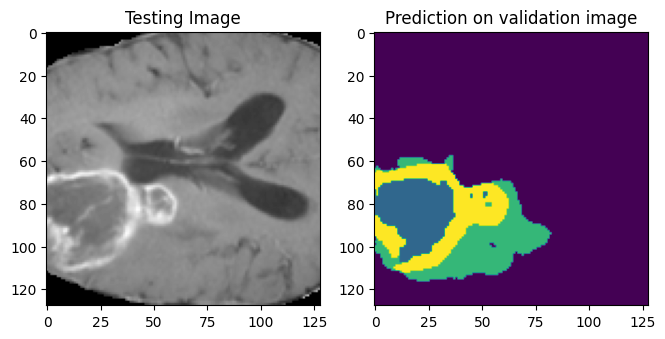

In [74]:
n_slice = 60
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,n_slice,1], cmap='gray')
#plt.subplot(232)
#plt.title('Testing Label')
#plt.imshow(test_mask_argmax[:,:,n_slice])
plt.subplot(232)
plt.title('Prediction on validation image')
plt.imshow(test_prediction_argmax[:,:, n_slice])
plt.show()
